# Описание проекта
Заказчик - магазин строительных материалов "Строили, строили и наконец построили"

**Цель проекта - изучить данные и сделать программу лояльности эффективнее.** Необходимо определить главные метрики и понять, хорошо ли работает действующая программа, можно ли ее улучшить. Отчёт предоставить заказчику в виде презентации.

Работа состоит из 5-ти этапов, каждый из которых сопровожден постановкой цели и выводом. В конце необходимо ответить на вопросы заказчика, сделать общий вывод и дать рекомендации.

Стоит отметить, что "лояльность" - это эмоциональная привязанность, преданность клиента к бренду или точке продажи. Главная задача программы - повышение прибыли, а это значит, что, опираясь на запрос заказчика, необходимо проанализировать эффективность программы лояльности и предоставить рекомендации по её улучшению. 

**Описание данных** 
<br>

Файл **retail_dataset.csv**:
* purchaseId — id чека;
* item_ID — id товара;
* purchasedate — дата покупки;
* Quantity — количество товара;
* CustomerID — id покупателя;
* ShopID — id магазина;
* loyalty_program — участвует ли покупатель в программе лояльности;

Файл **product_codes.csv**:
* productID — id товара;
* price_per_one — стоимость одной единицы товара;


# Этап 1: Предобработка данных

In [1]:
#подключаем бтблиотеки
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import math as mth
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go
from folium import Marker, Map
from folium import Map, Choropleth
from folium.plugins import MarkerCluster

ModuleNotFoundError: No module named 'folium'

In [ ]:
try:
    retail, product = pd.read_csv('/datasets/retail_dataset.csv'), pd.read_csv('/datasets/product_codes.csv')
except: 
    retail, product = pd.read_csv(' https://code.s3.yandex.net/datasets/retail_dataset.csv'), pd.read_csv(' https://code.s3.yandex.net/datasets/product_codes.csv')


# 1 Обработка файла retail_dataset.csv

In [ ]:
print(retail.head(20))
print(retail.info())
print(retail.describe())

In [ ]:
retail.hist(figsize=(10, 10))

**В данных замечены следующие проблемы:**
1. Следует заменить названия столбцов
2. Неверные типы данных
3. Присутсвуют аномальные значения:
    * Почему в Quantity присутствуют отрицательные значения?
    * Что означают пропуски в customer_id?
4. Данные не полные

In [ ]:
#Заменим названия солбцов
retail.rename(columns={'purchaseid':'purchase_id', 'item_ID':'item_id', 'Quantity':'quantity', 'purchasedate':'purchase_date', 'CustomerID':'customer_id', 'ShopID':'shop_id'},  inplace=True)

In [ ]:
retail.isna().sum()#выведем количество пропущенных значений для каждого столбца

In [ ]:
retail.isna().mean()*100 #изучим долю пропущенных значений

In [ ]:
print (f'В датасете {retail[retail["quantity"] < 0]["purchase_id"].count()} строк с отрицательным значением')
print (f'Процент отрицательных значений от общего чсла строк равен {round(((retail[retail["quantity"] < 0]["purchase_id"].count()) * 100) / retail["quantity"].count(),2)}')


Таким образом, несмотря на большое количество строк с отрицательным значением, их процент от общего числа составляет всего 2.01%. Данные значения могли  возникунуть по двум причинам - возвраты или ошибка кассы. Проанализириуем их позже.

Единственный сотлбец с пропусками - customer_id. При этом 34% пропусков от общего количества данных - это слишком много, чтобы просто удалить их. Есть предположение, что это покупатели без персональных карт. Пока что заменим пропуски на 0 и оставим бзе изменений. Возможно, в дальнейшем нам понадобится эта информация.

In [ ]:
retail['customer_id'] = retail['customer_id'].fillna(0)

In [ ]:
#Обработаем дубликаты
retail.duplicated().sum()

In [ ]:
print(f'Доля дубликатов: {retail.duplicated().sum()/retail.shape[0] *100}')

Несмотря на то, что доля дубликатов небольшая, удалять их не стоит, так как в одном чеке один товар может фигурировать не один раз (например, если пробивается два раза и более)

In [ ]:
#Заменим типы
retail['customer_id']=retail['customer_id'].astype(int)
retail['loyalty_program']=retail['loyalty_program'].astype(int)
retail['purchase_date'] = pd.to_datetime(retail['purchase_date']) 

In [ ]:
# Что значат пропуски в customer_id?
retail.query('customer_id == 0').groupby(['loyalty_program'])['loyalty_program'].sum()

Таким образом, мы выяснили, что покупатели с id=0 - это покупатели без персональных карт, которые не учавствуют в программе лояльности.

# 2 Обработка файла product_codes.csv

In [ ]:
print(product.head(20))
print(product.info())
print(product.describe())

In [ ]:
product.hist(figsize=(10, 10))

**В данных замечены следующие проблемы:**
1. Следует заменить названия столбцов
2. Присутсвуют аномальные значения

In [ ]:
# Заменим названия столбцов
product.rename(columns={'productID':'product_id'},  inplace=True)

In [ ]:
product.isna().sum()#выведем количество пропущенных значений для каждого столбца

In [ ]:
product.duplicated().sum()

In [ ]:
product[product['product_id']=='21873']

Есть особенность - для некоторых товаров указано сразу несколько цен. Возможно это связано со скидакми, акциями, купонами или просто магазин менял цены на некоторые товары. В любом случае, данная особенность мешает нам связать таблицы. Чтобы исправить это, для каждого товара посчитаем среднюю цену.   

In [ ]:
product = product.groupby('product_id', as_index=False)['price_per_one'].agg('mean')

In [ ]:
product

In [ ]:
# Объединим таблицы 
data = retail.merge(product, left_on='item_id', right_on='product_id', how='inner')
data

***Добавим новые столбцы***

In [ ]:
# Добавляю столбец с общей суммой покупки
data['revenue'] = data['quantity'] * data['price_per_one']
# Добавил в таблицу столбец с днем
data['purchase_day'] = data['purchase_date'].dt.date
# Добавил в таблицу столбец с месяцем
data['purchase_month'] = data['purchase_date'].dt.to_period('m')
# Добавление столбца с месяцем первой покупки
order = data.groupby('customer_id')['purchase_date'].min() 
order.name = 'first_order_date'
data = data.join(order,on = 'customer_id')
data['first_order_month'] = data['first_order_date'].dt.to_period('m')
# Добавление столбца lifetime
data['lifetime'] = data['purchase_month'].astype(int) - data['first_order_month'].astype(int)
# Добавление столбца lifetime в днях
data['lifetime_day'] = (data['purchase_date'] - data['first_order_date']).dt.days

In [ ]:
data.drop('product_id', axis= 1 , inplace= True ) #Удалим столбец product_id, так как он полностью дублируе столбец item_id
data

In [ ]:
print(np.percentile(data['revenue'], [90, 95, 99]))
print(np.percentile(data['quantity'], [90, 95, 99]))

In [ ]:
data = data.query('quantity < 25') #Уберем слишком крупные заказы

data = data.query('revenue < 90')

**Вывод**

1. Заменили названия некоторых столбцов 
2. Привели данные к верным типам
3. Проверили датасеты на наличие пропусков. Выяснили, пропуски в retail['customer_id'] означают, что у клиента нет карты и он не учавтсвует в программе лоялности.
4. Проверили датасеты на наличие дубликатов. Выяснили, что дубликаты в таблице retail - норма в нашем случае, так как в одном чеке один товар может фигурировать не один раз.
5. Обнаружили, что в таблице product для некоторых товаров указано несколько цен. Эта особенность объяснима тем, что магазин иногда действитльно менят цены на товары. Для последующего объединения таблиц посчитали среднюю цену для каждого товара.
6. Были найдены и другие аномалии, а именно отрицательные значения в quantity. В датасете 2118 строк с отрицательным значением, что составляет всего 2.01%. Данные значения могли возникунуть по двум причинам - возвраты или ошибка кассы. В дальейшем они не понадобятся, поэтому удалим их.
7. Объединили таблицы retail и product
8. Добавили новые столбцы


# Этап 2: Исследовательский анализ данных

Разделим этап на две части:

Исследовательский анализ данных
Исследовательский анализ программы лояльности
Задача каждого этапа - исследовать данные, выявить закономерности, обработать аномалии, ответить на вопросы и выдвинуть гипотезы.

# 1 Анализ данных

**1.1. Магазин и товары:**

In [2]:
print(f"В датасете содержатся даные о {len(data['shop_id'].unique())}-ти магазинах") 

NameError: name 'data' is not defined

In [3]:
data['shop_id'].value_counts().sort_values()
#Мы видим, что Shop_0, Shop_4, Shop_1, Shop_6 - пользуются спросом. Остальные точки продажи непопулярны.

NameError: name 'data' is not defined

In [4]:
data.groupby(['shop_id'])['loyalty_program'].sum() #из всех магазинов ПЛ работает только в Shop_0, Shop_19, Shop_28, Shop_8

NameError: name 'data' is not defined

In [5]:
print(f"В магазине {len(data['item_id'].unique())} разных товаров") 

NameError: name 'data' is not defined

In [6]:
data['item_id'].value_counts().sort_values(ascending=False).head(20) #ТОП-20 по популярности товаров 

NameError: name 'data' is not defined

Проанализируем чеки с отирцательной суммой. Как уже упомяналось ранее, данные значения могли возникунуть по двум причинам - возвраты или ошибка кассы.

In [7]:
negative_quantity = data.query('quantity < 0')
negative_quantity

NameError: name 'data' is not defined

In [8]:
negative_quantity.query('quantity < 0').groupby('loyalty_program')['customer_id'].count()

NameError: name 'negative_quantity' is not defined

In [9]:
negative_quantity.query('quantity < 0').groupby('purchase_month')['customer_id'].count()

NameError: name 'negative_quantity' is not defined

In [10]:
negative_quantity.query('purchase_id == "C%"').groupby('purchase_month')['customer_id'].count()

NameError: name 'negative_quantity' is not defined

In [167]:
c=0
if __name__ == '__main__':
    for s in negative_quantity['purchase_id']:
        ch = 'C'
        if ch in s:
            c+=1
        else:
            c+=0
print(c)


1904


Таким образом, у большей части товаров с негативным значением есть приставка "C", то есть "Статус in cancel" - продавец отменил заказ. Это может произойти по разным причинам, например, если товар уже не доступен для продажи или если продавец не может выполнить заказ по какой-то другой причине.

**1.2. Время**

In [168]:
print (f'Минимальная дата {data["purchase_date"].min()}', f'Максимальная дата {data["purchase_date"].max()}', sep='\n')

Минимальная дата 2016-12-01 08:26:00
Максимальная дата 2017-02-28 17:04:00


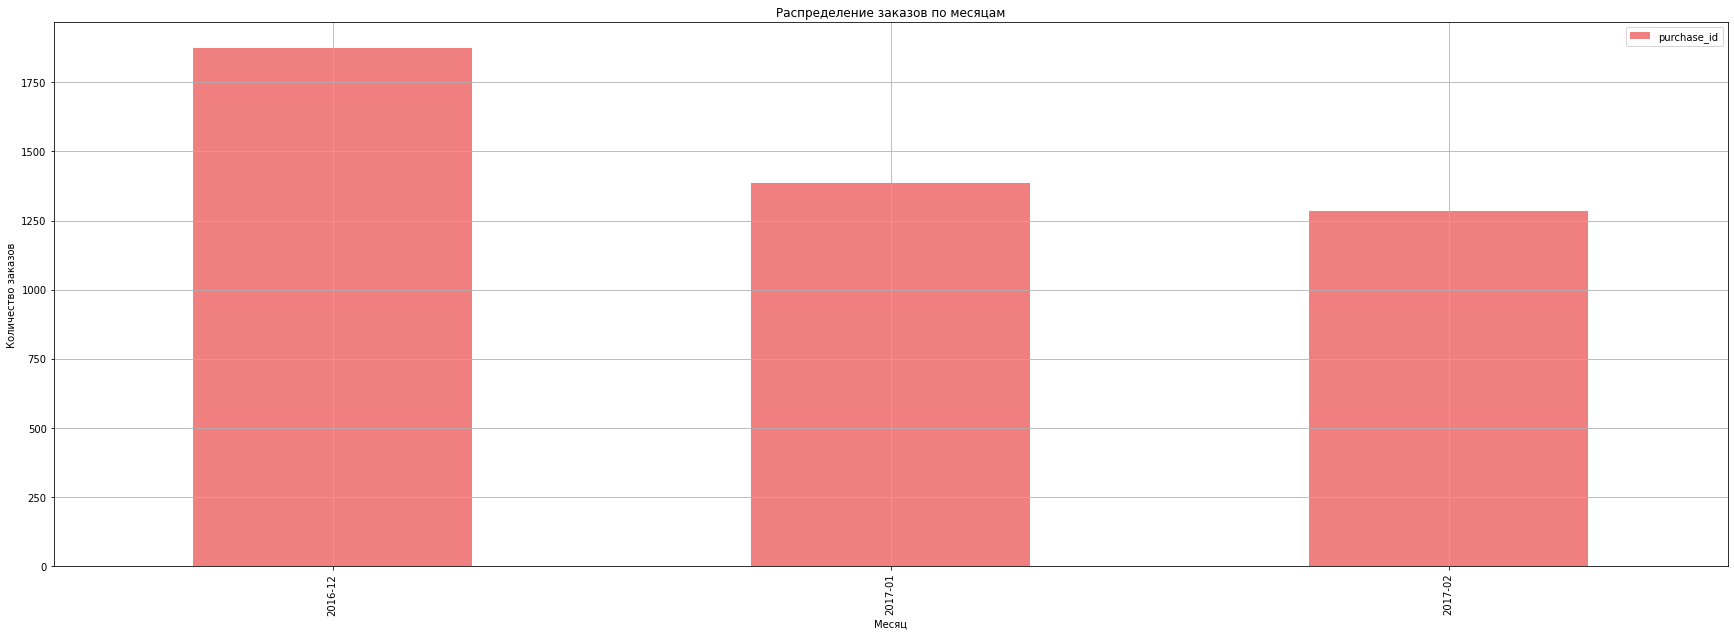

In [169]:
#Распределим события по времени (месяцы)
data.pivot_table(index = 'purchase_month', values = 'purchase_id', aggfunc = 'nunique').plot(kind = 'bar', figsize = (30, 10), color = '#F08080', grid = True)
plt.title('Распределение заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

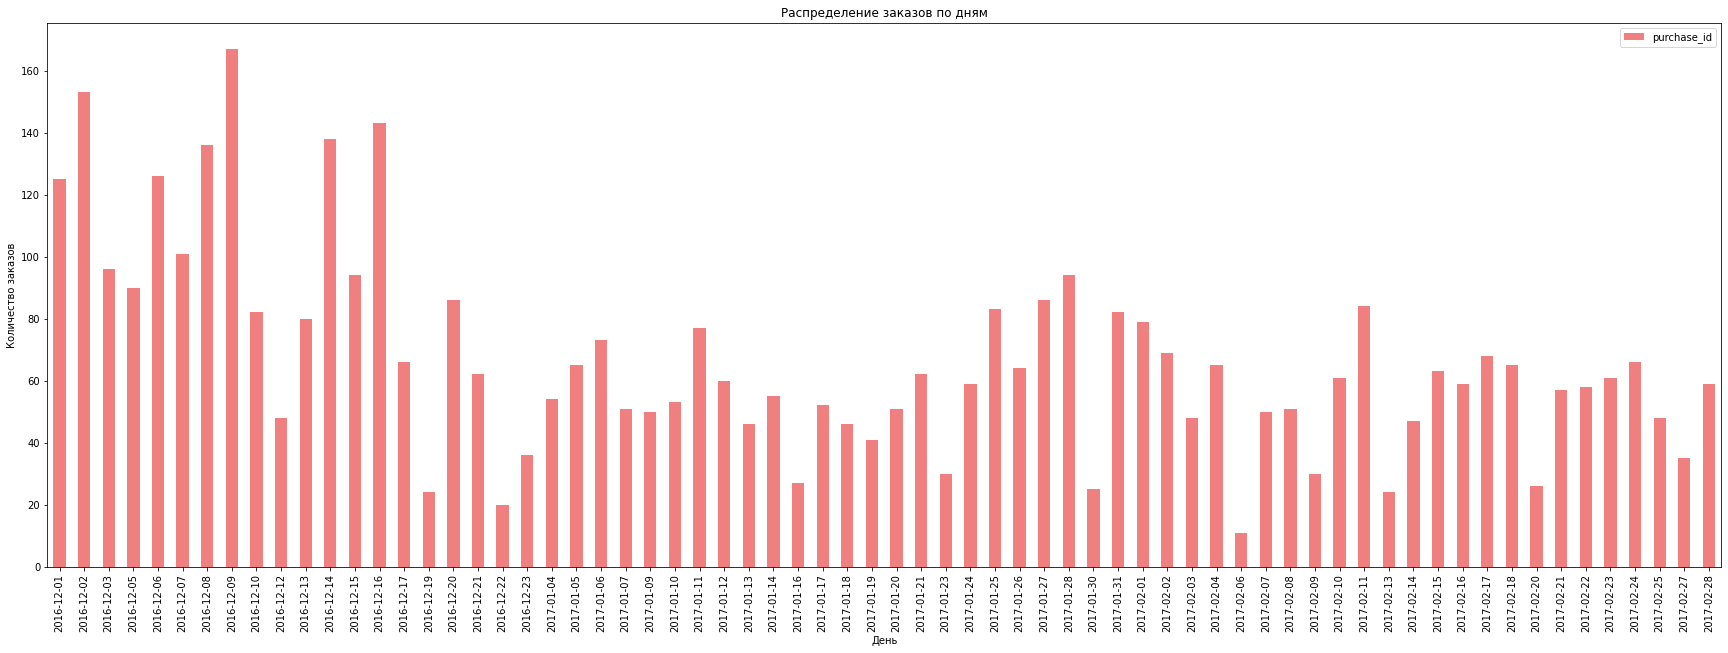

In [170]:
#Распределим события по времени (дни)
data.pivot_table(index = 'purchase_day', values = 'purchase_id', aggfunc = 'nunique').plot(kind = 'bar', figsize = (30, 10), color = '#F08080')
plt.title('Распределение заказов по дням')
plt.xlabel('День')
plt.ylabel('Количество заказов')
plt.show()

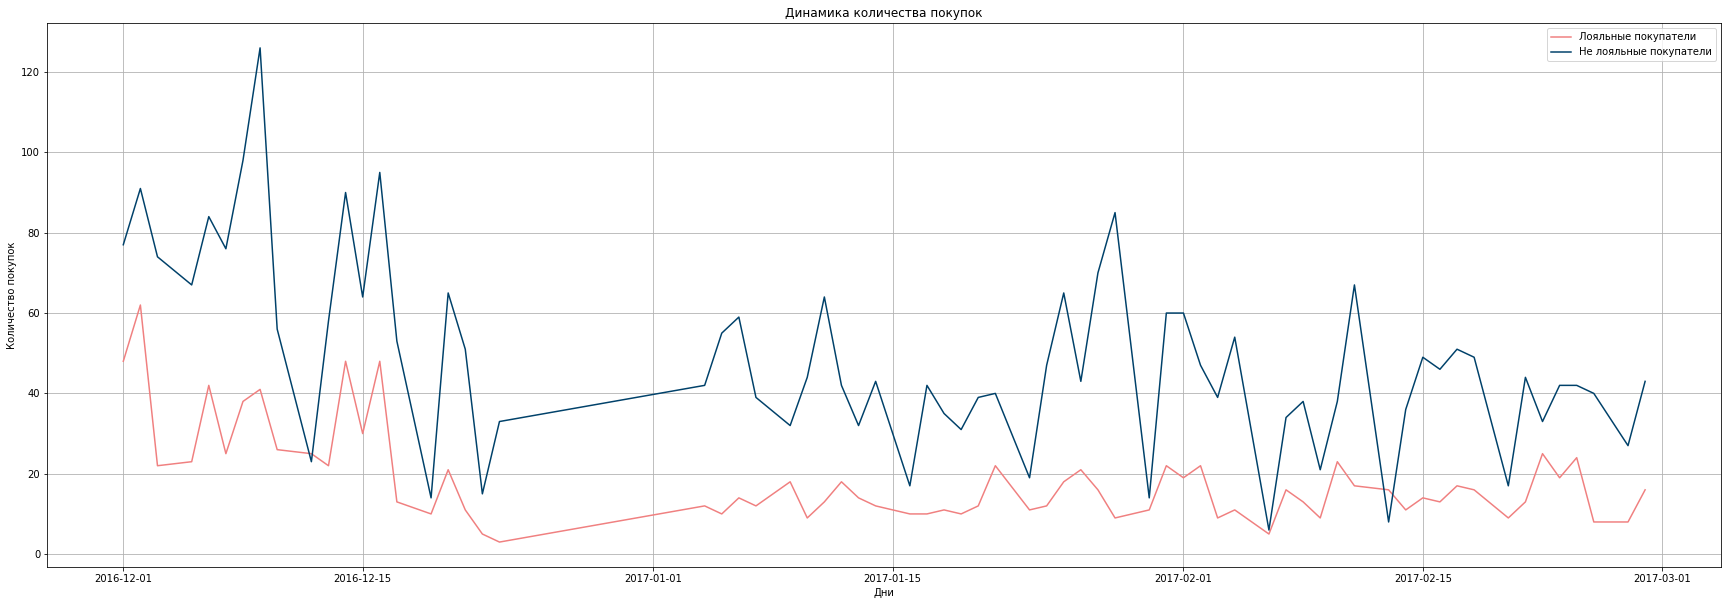

In [171]:
#Динамика количества покупок
purchase = data.pivot_table(index = ['purchase_day', 'loyalty_program'], values = 'purchase_id', aggfunc = 'nunique').reset_index()
fig = plt.figure(figsize = (30, 10))
graph = fig.add_subplot()
purchase.query('loyalty_program == 1').plot(x = 'purchase_day', y = 'purchase_id', ax = graph, label = 'Лояльные покупатели', color = '#F08080')
purchase.query('loyalty_program == 0').plot(x = 'purchase_day', y = 'purchase_id', ax = graph, label = 'Не лояльные покупатели', color = '#00416a')
graph.set_title('Динамика количества покупок')
graph.set_xlabel('Дни')
graph.set_ylabel('Количество покупок')
graph.grid(True)

**Вывод**
* В датасете содержатся данные о 30-ти магазинах
* Из них наибольшее количетво посеителей/покупок в  Shop_0, Shop_4, Shop_1, Shop_6
* Также из всех магазинов ПЛ работает только в Shop_0, Shop_19, Shop_28, Shop_8
* В ассортименте магазина 3159 рзных товаров
* Был выявлен ТОП самых популярных товаров
* Мы распологаем данными за 3 зимних месяца (с 2016-12-01 по 2017-02-28)
* За это время наиболшее число покупок пришлось на декабрь - больше 1400 чеков. В январе и феврале показатели примерно равны


# 2 Анализ прогрыммы лояльности

Чтобы определить, эффективна ли программа лояльности, определим:
1. Средний чек у лояла должен быть больше 
2. Лояльный покупатель возвращается в магазин
3. Среднее количество товароы в чеке?
4. 

In [172]:
#предварительно избавимся от отрицательных значений в quantity
data_t = data
data = data.query('quantity >= 0')

In [173]:
print(f"За три месяца магазин посетили {len(data.groupby('customer_id'))} клентов") 
print(f"Количество лояльных покупателей {len(data.query('loyalty_program == 1').groupby('customer_id')['loyalty_program'].sum())}") 

За три месяца магазин посетили 1595 клентов
Количество лояльных покупателей 536


In [174]:
print(f'Средний чек лоялов: {round(data[data["loyalty_program"] == 1].groupby("purchase_id")["revenue"].sum().mean(),2)}')
print(f'Средний чек не лоялов: {round(data[data["loyalty_program"] == 0].groupby("purchase_id")["revenue"].sum().mean(),2)}')

Средний чек лоялов: 256.0
Средний чек не лоялов: 317.2


Посмотрм на средний чек в динамике

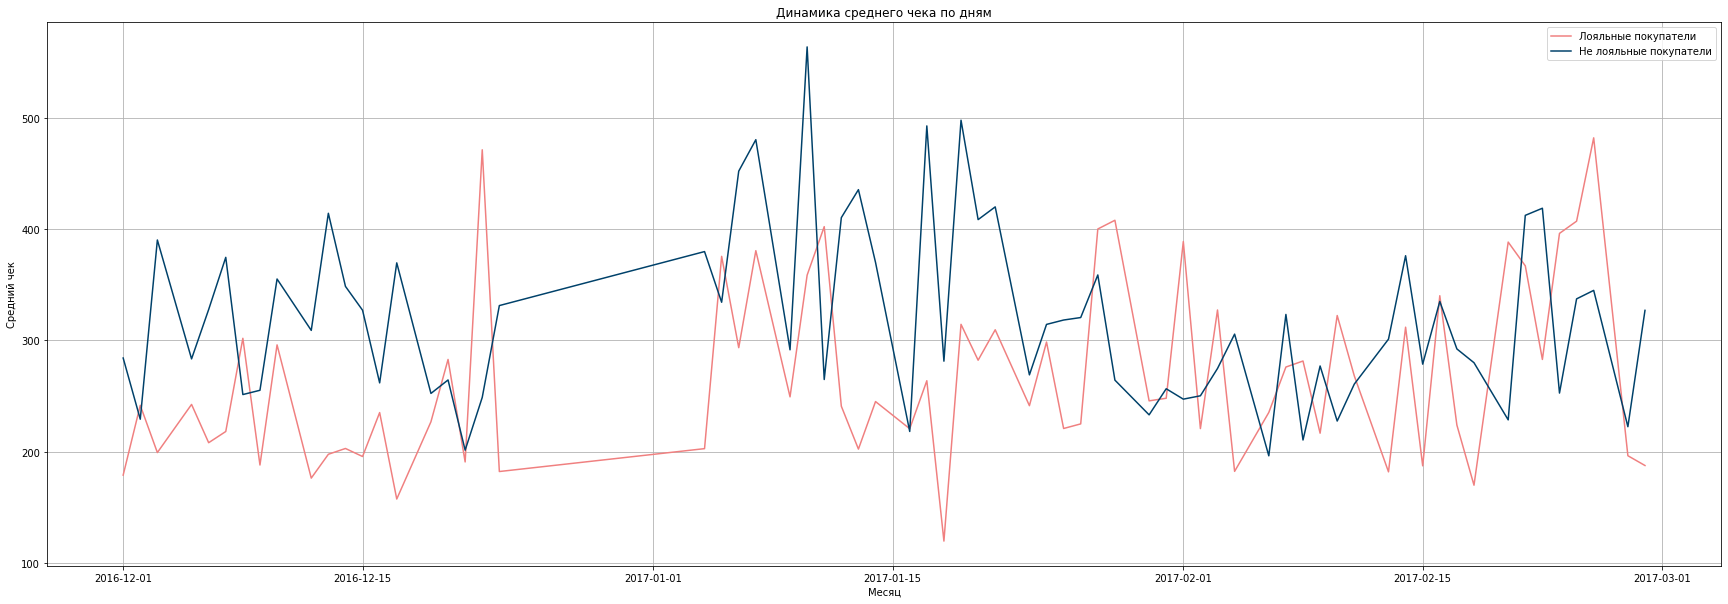

In [175]:
d = []
for a in data['purchase_day'].unique():
    d.append([a, data[(data['purchase_day'] == a)&(data['loyalty_program'] == 1)].groupby('purchase_id')['revenue'].sum().mean()])
loy = pd.DataFrame(d).sort_values(0)
loy.columns = ['day', 'avg_bill']
d = []
for a in data['purchase_day'].unique():
    d.append([a, data[(data['purchase_day'] == a)&(data['loyalty_program'] == 0)].groupby('purchase_id')['revenue'].sum().mean()])
neloy = pd.DataFrame(d).sort_values(0)
neloy.columns = ['day', 'avg_bill']

fig = plt.figure(figsize = (30, 10))
graph = fig.add_subplot()
loy.plot(x = 'day', y = 'avg_bill', ax = graph, label = 'Лояльные покупатели', color = '#F08080')
neloy.plot(x = 'day', y = 'avg_bill', ax = graph, label = 'Не лояльные покупатели', color = '#00416a')
graph.set_title('Динамика среднего чека по дням')
graph.set_xlabel('Месяц')
graph.set_ylabel('Средний чек')
graph.grid(True)

Проверим, возвращаются ли клиенты?

In [176]:
loy_cl_return = data.query('loyalty_program == 1').pivot_table(index='customer_id', values='purchase_id', aggfunc='count').reset_index()
loy_cl_return.columns = ['customer_id','purchase_count']
loy_cl_return.sort_values(by='purchase_count', ascending=False) #Сколько покупок совершили лоялы? Возвращаются ли они?

,customer_id,purchase_count
418,23520,729
497,23797,321
422,23529,296
274,23016,258
410,23490,252
...,...,...
284,23040,1
94,22371,1
62,22233,1
118,22444,1


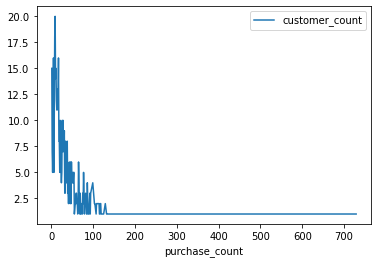

In [177]:
cl = loy_cl_return.pivot_table(index='purchase_count', values='customer_id', aggfunc='count').reset_index()
cl.columns = ['purchase_count', 'customer_count']
cl.plot(x="purchase_count", y="customer_count")
plt.show() #Сколько клиентов совершили х поукпок?

In [178]:
#Выделим отдельную категорию людей "почти лоялы"
neloy_cl_return = data.query('loyalty_program == 0 and customer_id != 0').pivot_table(index='customer_id', values='purchase_id', aggfunc='count').reset_index()
neloy_cl_return.columns = ['customer_id','purchase_count']
neloy_cl_return.sort_values(by='purchase_count', ascending=False) #Сколько покупок совершили лоялы? Возвращаются ли они?

,customer_id,purchase_count
133,18427,773
630,20285,722
807,20990,617
711,20590,448
735,20718,423
...,...,...
775,20876,1
129,18415,1
298,19047,1
951,21564,1


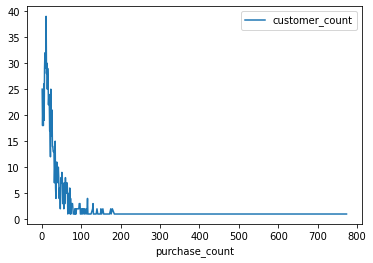

In [179]:
cl_neloy = neloy_cl_return.pivot_table(index='purchase_count', values='customer_id', aggfunc='count').reset_index()
cl_neloy.columns = ['purchase_count', 'customer_count']
cl_neloy #Сколько клиентов совершили х поукпок?
cl_neloy.plot(x="purchase_count", y="customer_count")
plt.show()

Сколько не лояльных покупателей, которые активно пользуются магазином? Почему они не участники программы? - Выделим отдельную категорию людей "почти лоялы"

In [180]:
cl_neloy.query('purchase_count > 2')['customer_count'].sum()

1015

In [181]:
data = data_t

**Таким образом:**
* Общее число клиентов, не учавствующих в программе, больше в три раза
* Средний чек лояльного покупателя меньше чем у не лояльного 20%
* Динамика среднего чека показала, что срениий чек не лояльного покупателя почти всегда выше, чем у лояльного
* Лояльные покупатели действительно покупают чаще
* 268 клиентов, не учавствующих в программе лояльности активно пользуются магазином - это потенциальные участники программы.

# Рассчет экономических метрик

In [182]:
# Функция для создания профиля пользователя
def get_profiles(data):
    profiles = (
        data.sort_values(by=['customer_id', 'purchase_date'])
        .groupby('customer_id')
        .agg(
            {
                'purchase_date': 'first',
                'loyalty_program': 'first',
            })
        .rename(columns={'purchase_date': 'first_ts'})
        .reset_index())
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    new_users = (
        profiles.groupby(['dt', 'loyalty_program'])
        .agg({'customer_id': 'nunique'})
        .rename(columns={'customer_id': 'unique_users'})
        .reset_index())
    return profiles

In [183]:
# Функция для нахождения LTV
def get_ltv(
    profiles,  
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['customer_id', 'purchase_date', 'revenue', 'loyalty_program']],
        on='customer_id',
        how='left',)
    result_raw['lifetime'] = (
        result_raw['purchase_date'] - result_raw['first_ts']).dt.days
    result_raw = result_raw.rename(columns={'loyalty_program_x': 'loyalty_program'})
    result_raw = result_raw.drop(columns = 'loyalty_program_y')
    result_raw_loy = result_raw[result_raw['loyalty_program'] == 1]
    result_raw_neloy = result_raw[result_raw['loyalty_program'] == 0]
    result_raw_loy['revenue'] = ((round(result_raw_loy['lifetime'] / 30, 1)) * 200) + result_raw_loy['revenue']
    result_raw = pd.concat([
        result_raw_loy,
        result_raw_neloy])
    result_raw = result_raw.drop(columns = 'loyalty_program')
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  
            aggfunc='sum',)
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days)
    return result_raw, result_grouped, result_in_time

In [184]:
# Профили пользователей
profiles = get_profiles(data)

print (f"Минимальная дата {profiles['first_ts'].min()}", f"Максимальная дата {profiles['first_ts'].max()}", sep='\n')

Минимальная дата 2016-12-01 08:26:00
Максимальная дата 2017-02-28 17:01:00


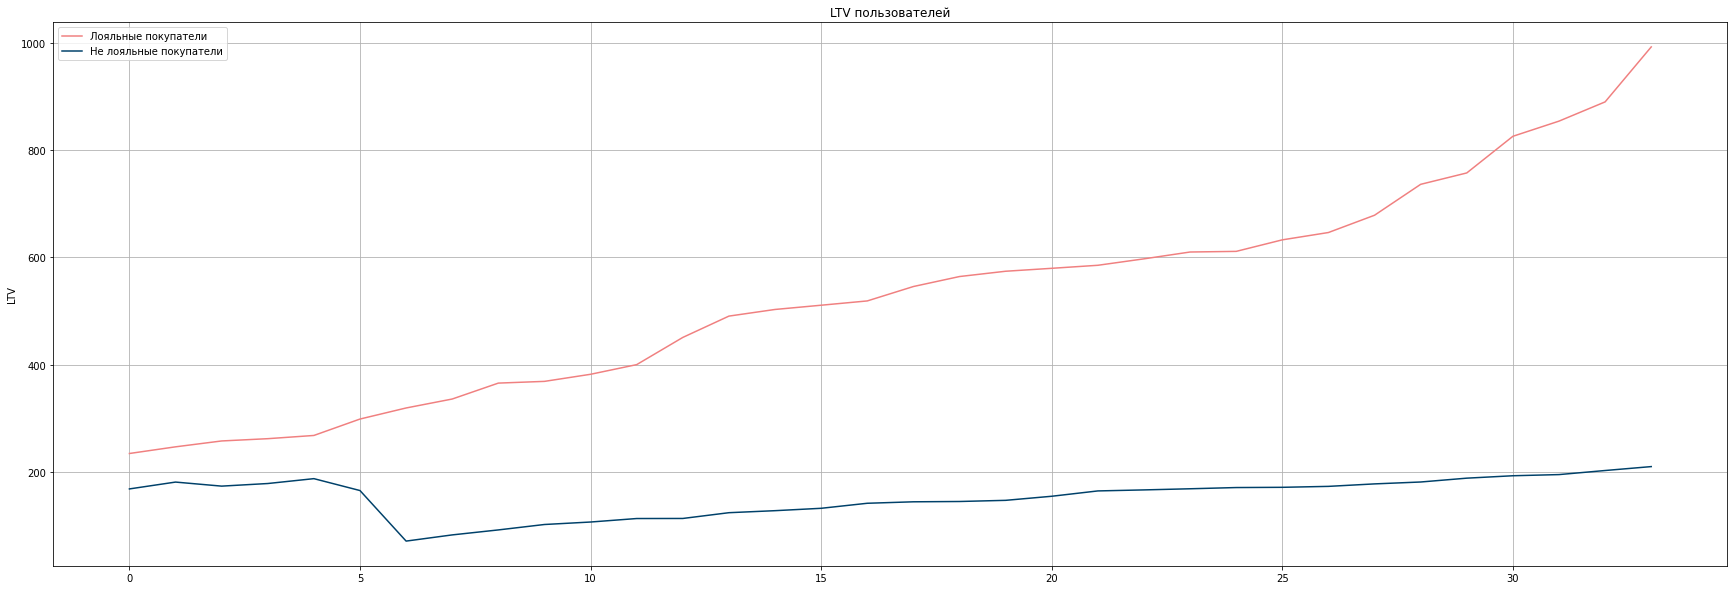

In [185]:
observation_date = datetime(2017, 2, 28).date()
horizon_days = 34 #беру максимально возможный (изначально хотела взять 60, но 34 - возможный максимум)

ltv_raw_neloy, ltv_neloy, ltv_history_neloy = get_ltv(
    profiles[profiles['loyalty_program'] == 0], data, observation_date, horizon_days)
ltv_raw_loy, ltv_loy, ltv_history_loy = get_ltv(
    profiles[profiles['loyalty_program'] == 1], data, observation_date, horizon_days)
ltv_loy = ltv_loy.drop(columns=['cohort_size'])
ltv_neloy = ltv_neloy.drop(columns=['cohort_size'])


fig = plt.figure(figsize = (30, 10))
graph = fig.add_subplot()
ltv_loy.T.plot(ax = graph, label = 'Лояльные покупатели', color = '#F08080')
ltv_neloy.T.plot(ax = graph, label = 'Не лояльные покупатели', color = '#00416a')
graph.set_title('LTV пользователей')
graph.legend(['Лояльные покупатели', 'Не лояльные покупатели'])
graph.set_ylabel('LTV')
graph.grid(True)

По показателю LTV изначальными лидерами являются клиенты, не учавствующие в программе лояльности. На 12 день жизни клиенты, учавствующие в программе лояльности, уверенно опережают обычных покупателей. К 30 дню жизни, клиенты с картами лояльности операжают обычным клиентов почти в 2 раза.

# Оценка пользовательской активности


Посчитаем следующие метрики для оценки пользовательской активности:
* DAU — количество уникальных пользователей в день;
* WAU — количество уникальных пользователей в неделю;
* MAU — количество уникальных пользователей в месяц.

In [186]:
# выделяем год, номер месяца и номер недели из времени начала сессии
data['session_year'] = data['purchase_date'].dt.year
data['session_month'] = data['purchase_date'].dt.month
data['session_week'] = data['purchase_date'].dt.isocalendar().week
data['session_date'] = data['purchase_date'].dt.date

In [187]:
#Посчитаем DAU и WAU. Сгруппируем данные по дате и неделе, 
# посчитаем количество уникальных пользователей по столбцу client_id и найдём среднее.

dau_total = (
    data.groupby('session_date').agg({'customer_id': 'nunique'}).mean()
)

wau_total = (
    data.groupby(['session_year', 'session_week'])
    .agg({'customer_id': 'nunique'})
    .mean()
)

mau_total = (
    data.groupby(['session_year', 'session_month'])
    .agg({'customer_id': 'nunique'})
    .mean()
)


print(f'количество уникальных пользователей в день: {int(dau_total)}')
print(f'количество уникальных пользователей в неделю: {int(wau_total)}') 
print(f'количество уникальных пользователей в месяц: {int(mau_total)}') 

количество уникальных пользователей в день: 50
количество уникальных пользователей в неделю: 239
количество уникальных пользователей в месяц: 800


Также найдем sticky factor. Sticky factor отражает регулярность использования сервиса или приложения и для недельной аудитории.

In [188]:
# умножаем на 100, чтобы получить проценты
print(dau_total / wau_total * 100) #для недельной аудитории
print(dau_total / mau_total * 100) #для месячной аудитории

customer_id    21.060772
dtype: float64
customer_id    6.290714
dtype: float64


#  Этап 3: Проверка гипотез

In [189]:
test_group = data.groupby(['customer_id', 'loyalty_program']).agg({'purchase_id' : 'nunique', 'price_per_one' : 'sum', 'revenue':'sum'}).reset_index()
test_group

,customer_id,loyalty_program,purchase_id,price_per_one,revenue
0,0,0,706,290396.111231,-111128.745584
1,18025,0,1,1.040000,-77184.640000
2,18026,0,2,240.228952,1475.902024
3,18027,0,2,38.979143,214.362286
4,18029,0,1,52.361000,385.261000
...,...,...,...,...,...
1670,23938,1,1,19.011032,212.179444
1671,23939,1,3,161.868529,757.104324
1672,23948,1,2,31.630000,162.555000
1673,23956,1,1,14.478333,-28.956667


**Гипотеза 1:**
- ***H0***: *Средний чек у лояльных и не лояльных покупателей равен.* 
- ***H1***: *Средний чек у лояльных и не лояльных покупателей не равен.* 

In [190]:
loy_data = data[data["loyalty_program"] == 1]
neloy_data = data[data["loyalty_program"] == 0]
loy_data_pivot = loy_data.pivot_table(index='purchase_id', values='revenue', aggfunc='sum').reset_index()
neloy_data_pivot = neloy_data.pivot_table(index='purchase_id', values='revenue', aggfunc='sum').reset_index()


In [191]:
results = st.mannwhitneyu(
    loy_data_pivot['revenue'],
    neloy_data_pivot['revenue'])

alpha = 0.05 # уровень статистической значимости

print('Значение p-value:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, есть статистически значимые различия в количестве покупок между группами")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет статистически значимых различий в количестве покупок между группами")

Значение p-value: 0.0019884348363856386
Отвергаем нулевую гипотезу, есть статистически значимые различия в количестве покупок между группами


**Гипотеза 2**
- ***H0:*** *Средний чек участников программы лояльности выше, чем у остальных покупателей*
- ***H1:*** *Средний чек участников программы лояльности не выше, чем у остальных покупателей.*

In [192]:
screens = neloy_data_pivot['revenue']
prev_screens_value  = loy_data_pivot['revenue']


results = st.ttest_ind(
    screens, 
    prev_screens_value) 

alpha = 0.05 # уровень статистической значимости
    
if (results.pvalue / 2 < alpha) and (screens.mean() < prev_screens_value):
    print("Не отвергаем нулевую гипотезу")
else:
    print("Отвергаем нулевую гипотезу") 


О отвергаем нулевую гипотезу


**Гипотеза 3:**
- ***H0***: *Среднее колиество покупок у лояльных и не лояльных покупателей равно.*
- ***H1***: *Среднее колиество покупок у лояльных и не лояльных покупателей не равно.* 

In [129]:
results = st.mannwhitneyu(
    test_group[test_group['loyalty_program'] == 0]['purchase_id'],
    test_group[test_group['loyalty_program'] == 1]['purchase_id'])

alpha = 0.05 # уровень статистической значимости

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, есть статистически значимые различия в количестве покупок между группами")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет статистически значимых различий в количестве покупок между группами")

p-значение: 0.03297195156433674
Отвергаем нулевую гипотезу, есть статистически значимые различия в количестве покупок между группами


# Этап 4: Общий вывод

Заказчик - магазин строительных материалов "Строили, строили и наконец построили"

Целью проекта было - изучить данные и сделать программу лояльности эффективнее, определить главные метрики и понять, хорошо ли работает действующая программа, можно ли ее улучшить. Отчёт предоставить заказчику в виде презентации.

Работа состоит из 5-ти этапов, каждый из которых сопровожден постановкой цели и выводом. 

Стоит отметить, что "лояльность" - это эмоциональная привязанность, преданность клиента к бренду или точке продажи. Главная задача программы - повышение прибыли, а это значит, что, опираясь на запрос заказчика, необходимо проанализировать эффективность программы лояльности и предоставить рекомендации по её улучшению.

**Выводы:**
* У 34% покупателей нет карты и он не учавтсвует в программе лоялности.
* В датасете содержатся данные о 30-ти магазинах. Из них наибольшее количетво посеителей/покупок в  Shop_0, Shop_4, Shop_1, Shop_6
* Также из всех магазинов ПЛ работает только в Shop_0, Shop_19, Shop_28, Shop_8
* Был выявлен ТОП самых популярных товаров
* Наиболшее число покупок пришлось на декабрь - больше 1400 чеков. В январе и феврале показатели примерно равны
* Общее число клиентов, не учавствующих в программе, больше в три раза
* Средний чек лояльного покупателя меньше чем у не лояльного 20%
* Динамика среднего чека показала, что срениий чек не лояльного покупателя почти всегда выше, чем у лояльного
* Лояльные покупатели действительно покупают чаще
* 268 клиентов, не учавствующих в программе лояльности активно пользуются магазином - это потенциальные участники программы.
* Количество уникальных пользователей в день/неделю/месяц равно соответственно 50/239/800
* Регулярность использования сервиса для недельной аудитории равна 21,06, а для месячной 6,29

**Проверка гипотез:**

**Гипотеза 1** о равенстве среднего чека у лояльных и не лояльных покупателей показала, что различия между чеками действительно есть. Более того, с учетом **Гипотезы 2**, мы не можем отрицать, что средний чек участников программы лояльности выше, чем у остальных покупателей. 

**Гипотеза 3** о равенстве среднего количества покупок у лояльные и не лояльных покупателей показала, что статистически значимые различия есть.


# Этап 5: Презентация

Ссылка на презентацию: https://disk.yandex.ru/i/ZXQ6rTkx-SiloQ

# Документация


Изувение программы лояльности:
* https://youtu.be/yDUPmTqKsmA
* https://blog.cardsmobile.ru/kak-razrabotat-uspeshnuyu-programmu-loyalnosti
* https://sendpulse.com/ru/support/glossary/loyalty-program
* https://kontur.ru/compass/spravka-compass/25088-loyalnost_klientov_chto_eto_i_kak_eyo_uvelichit